# Option Strategies 

In [62]:
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from datetime import datetime
import plotly.express as px
import holidays
import sympy
from scipy import optimize

In [63]:
from fredapi import Fred
api_fred = 'caf2a437b55be8f56406870c1bed3521'
fred = Fred(api_key= api_fred)
import quandl
quandl.api_config = 'J_fXGeVW_zC6RaDeJSQv'


In [64]:
class Contract:

    def __init__(self,S0,K,R,Sigma,T):
        """
        Class defines GBM contract
        S0: Spot price at time 0
        K: Strike price
        R: risk-free interest rate
        Sigma: annualized volatility of the option
        T: Time to maturity

        """
        self.S0 = S0
        self.K = K
        self.R = R
        self.Sigma = Sigma
        self.T = T
    def update_T(self,new_T:float):

        self.T = new_T
    def update_spot(self, Spot:float):
        self.S0 = Spot
    def update_rf(self, rf:float):
        self.R = rf
    def update_iv(self, IV:float):
        self.Sigma = IV
class CALL(Contract):

    def __init__(self,S0,K,R,Sigma,T):

        Contract.__init__(self,S0,K,R,Sigma,T)
        
    def update_T(self,new_T:float):

        self.T = new_T
    def update_spot(self, Spot:float):
        self.S0 = Spot
    def update_rf(self, rf:float):
        self.R = rf
    def update_iv(self, IV:float):
        self.Sigma = IV

class PUT(Contract):

    def __init__(self,S0,K,R,Sigma,T):

        Contract.__init__(self,S0,K,R,Sigma,T)
    def update_T(self,new_T:float):

        self.T = new_T
    def update_spot(self, Spot:float):
        self.S0 = Spot
    def update_rf(self, rf:float):
        self.R = rf
    def update_iv(self, IV:float):
        self.Sigma = IV

class Option_Pricer:

    def __init__(self,contract):

        """
        contract: use the CALL or PUT derived classes to defined the contract

        """

        self.contract = contract
        self.S0, self.K, self.R, self.Sigma, self.T = contract.S0,contract.K,contract.R,contract.Sigma, contract.T
        self.Type = self.contract.__class__.__name__

    def d1(self):
        D1 = (np.log(self.S0/self.K)+(self.R+ .5*self.Sigma**2)*self.T)/(self.Sigma*np.sqrt(self.T))
        return D1
    def d2(self):
        d_1 = self.d1()
        D2 = d_1 - self.Sigma*np.sqrt(self.T) 
        return D2
    def pv(self):
        return self.K*np.exp(-self.R*self.T)

    def __str__(self):

        return (f"{self.Type} option contract with strike {self.K} and volatility {self.Sigma}.")
        
    def price_derivative(self):
        D1 = self.d1()
        D2 = self.d2()
        PV = self.pv()

        if self.Type == 'CALL':

            return self.S0*stats.norm.cdf(D1)- PV*stats.norm.cdf(D2)
        else:

            return PV*stats.norm.cdf(-D2)-self.S0*stats.norm.cdf(-D1)

    def plot_contract(self):
        prices = self.price_derivative()

        if len(prices) <= 1:
            raise Exception('Cannot Graph 1 Price.')
        DF = pd.DataFrame(prices, index = self.S0, columns = [f"{self.Type}(K = {self.K})"])
        DF.index.name = 'Spot Price'

        fig = px.line(DF).update_layout(yaxis_title = 'Derivative Price')
        fig.add_shape(type ='line',x0 = self.K,x1 = self.K,y0= np.where(self.Type == 'CALL',0,),y1=np.where(self.Type == "CALL",max(prices),0), line = dict(color = "red"),name = 'Strike')

        return fig

    def plot_delta(self):
        title = f"{self.Type}(K = {self.K}, T = {self.T},vol = {self.Sigma},r = {self.R})"
        Deltas = self.delta()
        DF = pd.DataFrame(Deltas,index = self.S0, columns = [f"{self.Type}(K = {self.K})"])
        DF.index.name = 'Spot Price'

        fig = px.line(DF,title = title).update_layout(yaxis_title = "Delta")
        fig.add_shape(type ='line',x0 = self.K,x1 = self.K,y0= np.where(self.Type == 'CALL',0,-100),y1=np.where(self.Type == "CALL",100,0), line = dict(color = "red"),name = 'Strike')

        return fig
    def plot_gamma(self):

        title = f"{self.Type}(K = {self.K}, T = {self.T},vol = {self.Sigma},r = {self.R})"
        gammas = self.gamma()
        DF = pd.DataFrame(gammas,index = self.S0, columns = [f"{self.Type}(K = {self.K})"])
        DF.index.name = 'Spot Price'
        gamma_max = max(gammas)
        fig = px.line(DF,title = title).update_layout(yaxis_title = "Gamma")
        fig.add_shape(type ='line',x0 = self.K,x1 = self.K,y0=0,y1=gamma_max+1, line = dict(color = "red"),name = 'Strike')


        return fig
    def plot_vega(self):
        title = f"{self.Type}(K = {self.K}, T = {self.T},vol = {self.Sigma},r = {self.R})"
        vegas = self.vega()
        DF = pd.DataFrame(vegas,index = self.S0, columns = [f"{self.Type}(K = {self.K})"])
        DF.index.name = 'Spot Price'
        vega_max = max(vegas)
        fig = px.line(DF,title = title).update_layout(yaxis_title = "Vega")
        fig = fig.add_shape(type ='line',x0 = self.K,x1 = self.K,y0=0,y1=vega_max+1, line = dict(color = "red"),name = 'Strike')

        return fig
    def delta(self):
        if self.Type == 'CALL':
            return stats.norm.cdf(self.d1())
        else:
            return -stats.norm.cdf(-self.d1())
    def gamma(self):

        return stats.norm.pdf(self.d1())/(self.S0*self.Sigma*np.sqrt(self.T))

    def vega(self):

        return self.S0*np.sqrt(self.T)*stats.norm.pdf(self.d1())*1e-2
    def theta(self):
        if self.Type == 'CALL':
            return ((-self.S0*stats.norm.pdf(self.d1()) * self.Sigma)/(2*np.sqrt(self.T)) - self.R * self.K*np.exp(-self.R*self.T) * stats.norm.cdf(self.d2()))/365
        else:
            return ((-self.S0*stats.norm.pdf(self.d1()) * self.Sigma)/(2*np.sqrt(self.T)) +self.R * self.K*np.exp(-self.R*self.T) * stats.norm.cdf(-self.d2()))/365

            # Divide Theta by 252 trading days
    def return_values(self):

        price = self.price_derivative()
        delta =self.delta()
        gamma = self.gamma()
        vega = self.vega()
        theta = self.theta()
        vals = np.array([price,delta,gamma,vega,theta])
        df = pd.DataFrame([vals],columns = ['Price','Delta','Gamma','Vega','Theta'],index = [f'{self.Type}(K = {self.K})'])
        return df



In [65]:
start = '2015-01-01'
end = datetime.now()
onemonth = (pd.DataFrame(fred.get_series("DGS1MO",observation_start=start,observation_end=end),columns=['ONE_M'])*1e-2).dropna()
onemonth.tail(2)

,ONE_M
2023-12-29,0.0560
2024-01-02,0.0555


In [66]:
def set_up_matrix(portfolio:pd.DataFrame):
    newp = portfolio[['Delta','Vega']]
    return newp.T.iloc[:,:2]

# Put-Call Parity

**Forward Contract:** is a contract with a delivery price $K$ that obligates its holder to buy one share of the stock at expiration time $T$ in exchange for payment $K$. At expiration the value of the forward contract is $S(T) - K$. Let $f(t,x)$ denote the value of the forward contract at earlier times $t\in [0,T]$ if the stock price at time $\tau$ is $S(t)=x$, the value of the forward contract at time $\tau$ is :

\begin{align}

f(\tau,x) = x - e^{-r(T-\tau)}K

\end{align}

- Using no arbitrage pricing the payoff of the forward contract agrees with the payoff of a portfolio that is *long one call* and *short one put*, which can be summarized using this mathematical notation:

\begin{align}

f(t,x) &= c(\tau,x) - p(\tau,x)\\

x - e^{-r(T-\tau)}K &= c(\tau,x) - p(\tau,x)

\end{align}

# Put-Call-Parity

- For options with the same strike and expiration, the following relationship between two portfolos hold:

    1. A call option plus the discounted zero-coupon bond with payoff K at time $\tau$.
    2. A put option plus one share of stock

    Are both equal...

\begin{align}

C_o + K e^{rT} = S_o + P_o

\end{align}

# Covered Call | Buy-Write

A portfolio that consists of 1-share of stock and a short position in a European call option is known as a *covered call.*

<u>Example</u>

- Let's say we have 100 shares of an asset priced at $S_o = \$60.00$ and we want to write a call against the stock protecting us from a  $5\%$ decline in a period of 1 month, so we choose a strike price of $\$57.00$.

In [67]:
Ss = np.linspace(50,70,num = 161)
ivol1 = .20
Time = 30/365
r = 0.05
spot = 60
strike_ = 67
Vp = pd.DataFrame([100*spot],index = ['MV'])
co = Option_Pricer(CALL(S0 = spot, K = strike_, R = r, Sigma = ivol1,T = Time))
price_0 = co.price_derivative()*100


In [68]:
portfolio = 100*Ss + -np.maximum(Ss-57,0)*100 + (353.087)
covered_call = pd.DataFrame(portfolio,columns = ['MV'],index = Ss)
covered_call.index.name ='$ Underlying Price'
ccalfig = px.line(covered_call,title = 'Covered Call')

ccalfig.add_vline(x = 56.47,annotation = dict(text = f"Spot plus Credit {56.47}"))

- This is the exact payoff of writing a put with strike 57 plus investing the sale of $100 \cdot S_0 = \$6,000$ at the risk free rate for the remainder of the period.  

- Using put-call parity the price of the put is equal to $\$0.297108$.

In [69]:
synthetic_put = -np.maximum(57-Ss,0)*100 + 29.7108 + (6000*np.exp(r*Time))
synthetic_p = pd.DataFrame(synthetic_put,index = Ss)
px.line(synthetic_p)

What if I am short 100 shares of stock and buy a call option with strike price of 61? Assume you shorted the shares initially for $60.

- This is equivalent to buying a long synthetic put with strike of 61. 

In [70]:
co.return_values()

,Price,Delta,Gamma,Vega,Theta
CALL(K = 67),0.045277,0.034063,0.021965,0.012999,-0.004607


In [71]:
discounted = 61*np.exp(-r*(30/252))
putprice= 1.0382 - 60 + discounted
#putprice  = 178.80379221282183*1e-2

In [72]:
# using the previous example
co.K = 61

valueP = pd.DataFrame(-100*(Ss-spot),index = Ss,columns = ['Short_Stock_PNL']) 
valueP['Call(K=61)'] = np.maximum(Ss-61,0)*100 - 1.0382*100
valueP['Synthetic_Put'] = valueP.sum(axis = 1)
px.line(valueP)

- That is the payoff of your synthetic put. What would you pay for this put?

This put is equal to:

\begin{align}

P_0 &= C_o + Ke^{-r\tau} - S_0 \\

P_0 &= 1.03 +60.637 - 60 = \$1.676

\end{align}

- a long call option plus a short position in stock is equal to a long put option less a certain amount of cash $Ke^{r\tau}$. 

In [73]:
synthetic_put = pd.DataFrame(np.maximum(61-Ss,0) -putprice,columns =['Synthetic_Put61'],index = Ss)*100 -36
px.line(synthetic_put)

# Bull Call Spread 

- Simultaneously buy lower strike call and sell higher priced call
- This position profits when $S_T$ increases.

In [74]:
#C(K=95.5)
spot = 94.5
T = 30/252
r = 0.03
Lcall = Option_Pricer(CALL(S0=spot, K = 93.5,R = r, Sigma = .20, T = T))
Scall = Option_Pricer(CALL(S0 = spot, K = 95.5,R = r, Sigma= 0.185,T = T))

V0 = pd.concat([Lcall.return_values(),-1*Scall.return_values()],axis=0)
V0.loc['Net_Position',:] = V0.sum(axis= 0)
V0

,Price,Delta,Gamma,Vega,Theta
CALL(K = 93.5),3.303893,0.594999,0.059434,0.126372,-0.033433
CALL(K = 95.5),-2.098966,-0.469294,-0.065941,-0.129692,0.031081
Net_Position,1.204926,0.125705,-0.006507,-0.003320,-0.002352


# Bear Call Spread

- Simultaneoulsy *short* lower call strike and *buy* higher priced call
- This positions profits when $S_T$ decreases.

In [75]:
# Use the same options as before
-1*V0

,Price,Delta,Gamma,Vega,Theta
CALL(K = 93.5),-3.303893,-0.594999,-0.059434,-0.126372,0.033433
CALL(K = 95.5),2.098966,0.469294,0.065941,0.129692,-0.031081
Net_Position,-1.204926,-0.125705,0.006507,0.003320,0.002352


In [76]:
import pandas_market_calendars as mcal

# Create NYSE calendar
nyse = mcal.get_calendar('NYSE')

In [77]:
def generate_trade_days(begin_d, end_d):
    days = pd.date_range(start = begin_d,end = end_d)
    for i in days:
        if (i.weekday()>=5)or(i in holidays.US()):
            days = days.drop(i)
        else:
            continue
    return days
def market_days(begin_d, end_d):
    days = nyse.schedule(start_date = begin_d, end_date = end_d).index
    return days

# SPY Example

On interactive brokers we have $S_0 = 474.94$

- I am going to buy ITM call at $K = 471$ and sell OTM call at $K = 480$ to set up my initial **bull call spread.**

- The implied volatility for the lower strike is $12.2\%$ and $11.1\%$ for the higher strike. I am specificaly looking at options that expire on Febuary 16, 2024

In [78]:
t0 = datetime.now()
expiration_date = datetime(year = 2024, month = 2,day = 16)
T1 = len(generate_trade_days(begin_d=t0,end_d = expiration_date))/365
T1 = 49/365


spyspot = 474.94

spyl = Option_Pricer(CALL(S0=spyspot,K = 471,R = 0.0557,Sigma = 0.122,T = T1))
spyu = Option_Pricer(CALL(S0 = spyspot,K = 480,R = 0.0557, Sigma = 0.111,T = T1))
V_spy = pd.concat([spyl.return_values(),-spyu.return_values()],axis =0)
#V_spy.loc['Net_Position',:] = V_spy.sum(axis = 0)
initialp = V_spy.sum(axis = 0).to_frame('Bull_Spread').T
initialp


,Price,Delta,Gamma,Vega,Theta
Bull_Spread,5.648709,0.16902,-0.003112,-0.046275,-0.013407


In [79]:
S = np.linspace(450,510,endpoint=True,num = 61)
c1 = np.round(np.maximum(S-471,0) - 12.64,2)
c2 = np.round(-1*np.maximum(S-480,0) +7,2)
exp = c1+c2
bullspread = pd.Series(exp,index = S,name = 'PNL_Bull_Spread')
fig = px.line(bullspread,title = 'Bull Spread Strategy Payoff')
fig = fig.update_layout(yaxis_title = 'Profit',xaxis_title = 'Spot Price')
fig.add_hline(y = 0)
fig.show()

- Max profit from the bull spread is $\$9$-$\$5.64$ = $\$3.34$. This is equal to to *max payoff* less debit. 


In [80]:
A=np.array([[0.646538,-0.477519],[1,-1]])*100
b = np.array([50,0])
size = np.round(np.linalg.solve(A,b))

# Short Vertical Put Spread (Bull Put Spread)

- Here I will create the same payoff using Put Options
- Short higher strike put and buy lower strike put
- Positive $\Delta$ position.


In [81]:
putl = Option_Pricer(PUT(S0=spyspot,K = 471,R = 0.0557,Sigma = 0.122,T = T1))
putu = Option_Pricer(PUT(S0 = spyspot,K = 480,R = 0.0557, Sigma = 0.111,T = T1))
V_spy_P = pd.concat([putl.return_values(),-putu.return_values()],axis =0)
bull_put_spread = V_spy_P.sum(axis =0).to_frame("Bull Put Spread").T
bull_put_spread

,Price,Delta,Gamma,Vega,Theta
Bull Put Spread,-3.284244,0.16902,-0.003112,-0.046275,-0.01477


In [82]:
V_spy_P


,Price,Delta,Gamma,Vega,Theta
PUT(K = 471),5.197946,-0.353462,0.017509,0.646848,-0.054115
PUT(K = 480),-8.482190,0.522481,-0.020621,-0.693123,0.039344


In [83]:
# PUT EXPIRATION VALUES
putl_E = np.maximum(471-S,0)-5.1979
putu_E = -1*np.maximum(480-S,0) +8.482
put_spread = pd.Series(putl_E+putu_E,name ='PNL_Put_Spread',index = S)
ALL_Spreads =pd.concat([put_spread,bullspread],axis =1)
fig2 = px.line(ALL_Spreads.loc[470:483])
fig2.update_layout(yaxis_title= 'PNL')
fig2.add_hline(y = 0)

- What if I buy the bull spread and simultaneoulsy short the put spread of the option.

This means my initial portfolio looks like this at time $t_0$:

\begin{align}

V_0 &= \{\text{C(K= 471)} - \text{C(K = 480)}\} - \{\text{P(K = 471)} - \text{P(K = 480)}\} \\

V_T &= \$0.079/trade

\end{align}

In [84]:
ask_price  = -12.88+7.12-8.88+5.32
# PNL is the ask price plus tbe box which is $9
print(f"PNL from trade is ${ask_price+9:,.2f}")

PNL from trade is $-0.32


In [85]:
# Using actual bid ask prices from quoted calls and puts from interactive brokers
c471 = np.maximum(S-471,0) - 12.88
c480 = -1*np.maximum(S-480,0) + 7.12
p480 = np.maximum(480-S,0) - 8.88
p471 = -1*np.maximum(471-S,0) + 5.32
VT = pd.Series(c471+c480+p480+p471,name = 'Buy_Short_Spread',index = S)
# There actually is no arbitrage 

- In the example above the *payoff* from the Bull Call Spread dominates the put bull spread for all expiration prices. 

- When buying options compare the max profit from buying credit vs debit spread. 

# Put Spread Example

Suppose it is August 1, 2022 and you decide to buys 18 November 19 - 15 October 19 130 put spread when $S_0 = \$136.31$.


In [122]:
put_octT = len(market_days(begin_d="2022-08-01",end_d='2022-10-19'))/365
put_novT = len(market_days(begin_d="2022-08-01",end_d = "2022-11-19"))/365
p130oct= Option_Pricer(PUT(S0 = 136.31,K = 130, R = .05,Sigma = .2,T = put_octT))
p130nov = Option_Pricer(PUT(S0 = 136.31, K = 130, R= .05, Sigma=.23,T = put_novT))
port = pd.concat([-18*p130oct.return_values(),15*p130nov.return_values()],axis = 0)*100
port.loc['Initial',:] = port.sum(axis = 0).values
#port.sum(axis = 0).values
port

,Price,Delta,Gamma,Vega,Theta
PUT(K = 130),-2700.975497,414.457994,-50.764836,-294.598415,43.574926
PUT(K = 130),3918.502276,-412.584262,34.318786,317.431057,-37.967515
Initial,1217.526779,1.873732,-16.446050,22.832642,5.607411


# Short Call Time Value Spread

- This position is made when one shorts the further expiration call while simultaneously buying the closer expiration call option at the same strike price. 
- Overall $-\Delta$ position.

In [150]:
start_date = '2021-01-01'
closer_d = '2021-03-15'
further_d = '2021-04-20'
T_closer = len(market_days(begin_d=start_date,end_d=closer_d))/365
T_further = len(market_days(begin_d=start_date,end_d = further_d))/365
spot = 135
c_march = Option_Pricer(CALL(S0 = spot, K  = 135, R = .05, Sigma= 0.20, T=T_closer))
c_april = Option_Pricer(CALL(S0 = spot, K = 135, R = .05, Sigma = .2105, T= T_further))
port= pd.concat([-c_april.return_values(),c_march.return_values()],axis = 0)*100
port.loc['Initial',:] = port.sum(axis = 0).values
port

,Price,Delta,Gamma,Vega,Theta
CALL(K = 135),-578.677776,-56.133001,-3.080931,-23.962961,4.367051
CALL(K = 135),440.058389,55.102003,3.999665,19.571513,-4.952914
Initial,-138.619387,-1.030999,0.918734,-4.391448,-0.585863


In [149]:
time_frame = market_days(begin_d=start_date,end_d=closer_d)
simulated_values = 135*np.exp((.05 - .5*(.2**2))*T_closer + .2*np.sqrt(T_closer)*np.random.standard_normal(size= 100))
march_contract = np.maximum(simulated_values-135,0)
march_contract.mean()

4.385620611699875

# Long Straddle

- Buy and equal amount of calls and puts usually ATM



In [110]:
spot = 94.5
K_s = 95
T = 30/252
r = 0.03
sigma_straddle = 0.18
cstr = Option_Pricer(CALL(S0 = spot, K =K_s,R = r, T = T,Sigma= sigma_straddle))
pustr = Option_Pricer(PUT(S0=spot, K = K_s, R = r, Sigma = sigma_straddle,T= T))
P = pd.concat([cstr.return_values(),pustr.return_values()],axis = 0)*100
#P.loc['Net_Position',:] = P.sum()
P

,Price,Delta,Gamma,Vega,Theta
CALL(K = 95),226.324071,50.143209,6.797396,13.007668,-3.065057
PUT(K = 95),242.456015,-49.856791,6.797396,13.007668,-2.287019


- How would I make this position Delta neutral but Vega notional of 1000? This means that if implied volatility increases by one percent my expected profits are 1000. 

In [115]:
greeks = set_up_matrix(P)
#sizes also calculates correct allocation
sizes = np.floor(np.linalg.solve(greeks,np.array([0,1000])).reshape(2,1))

#size = np.linalg.solve(A,b)
# scaled everything down but set vega equation equal to 10 because 10*100 = $1000
A1 = np.array([[50.143,-49.85],[13.007,13.007]])*1e-2
b1 = np.array([0,1000])*1e-2

- Buy 38 calls and 38 puts

In [116]:
greeks

,CALL(K = 95),PUT(K = 95)
Delta,50.143209,-49.856791
Vega,13.007668,13.007668


In [117]:
positions = pd.DataFrame({'Size':sizes.flatten()},index = P.iloc[0:2].index)
positions

,Size
CALL(K = 95),38.0
PUT(K = 95),38.0


In [118]:
P.loc['Net_Position',:] = (P.iloc[0:2,:].T @ sizes).values.T
P

,Price,Delta,Gamma,Vega,Theta
CALL(K = 95),226.324071,50.143209,6.797396,13.007668,-3.065057
PUT(K = 95),242.456015,-49.856791,6.797396,13.007668,-2.287019
Net_Position,17813.643277,10.883874,516.602126,988.582744,-203.378909


**Initial Portfolio**
- Bought and sold 38 call and puts

|              |     Price |     $\Delta$ |    $\Gamma$ |    $\nu$ |      $\Theta$ |
|:-------------|----------:|----------:|---------:|---------:|-----------:|
| CALL(K = 95) |   2.26324 |  0.501432 | 0.067974 |  13.0077 | -0.0306506 |
| PUT(K = 95)  |   2.42456 | -0.498568 | 0.067974 |  13.0077 | -0.0228702 |
| Net_Position | 178.136   |  0.108839 | 5.16602  | 988.583  | -2.03379   |

Let's say the stock price moved to $\$98.5$ the next day. How many calls and puts would I need to sell in order to be delta = .2 and Vega notional 400?

In [91]:
# update S and T for the calls/puts
cstr.S0 = 98.5
pustr.S0 = 98.5
newT = 29/252
cstr.T = newT
pustr.T = newT
newp = pd.concat([cstr.return_values(),pustr.return_values()],axis = 0)
newp.loc['net_position',:] = (newp.T @ positions).values.T


In [92]:
newp

,Price,Delta,Gamma,Vega,Theta
CALL(K = 95),4.744795,0.751614,0.052652,0.105818,-0.028368
PUT(K = 95),0.917385,-0.248386,0.052652,0.105818,-0.020587
net_position,21717.655087,1922.902814,404.686868,813.320156,-188.049023


In [93]:
bcol = np.array([0.2,400]) - newp.loc['net_position',['Delta','Vega']]
bcol

Delta   -1922.702814
Vega     -413.320156
Name: net_position, dtype: float64

In [94]:
newdymanics = set_up_matrix(portfolio=newp)
positions['Size'] = sizes.flatten() + (np.linalg.solve(newdymanics,bcol))
positions

,Size
CALL(K = 95),939.115468
PUT(K = 95),2840.945776


In [95]:
newp_hedged  = newp.copy()
newp_hedged.loc['re_hedged',:] = (newp.iloc[0:2,:].T @ positions).values.T 
newp_hedged

,Price,Delta,Gamma,Vega,Theta
CALL(K = 95),4.744795,0.751614,0.052652,0.105818,-0.028368
PUT(K = 95),0.917385,-0.248386,0.052652,0.105818,-0.020587
net_position,21717.655087,1922.902814,404.686868,813.320156,-188.049023
re_hedged,7062.150200,0.200000,199.029553,400.000000,-85.127356


In [96]:
newp.iloc[0:2,:].T @ positions

,Size
Price,7062.150200
Delta,0.200000
Gamma,199.029553
Vega,400.000000
Theta,-85.127356


- I need to sell 29 calls and sell and additional 10 puts in order to make my current portfolio 0.2 delta and vega notional 400.


## Gamma Scalp

- For a **delta neutral portfolio**, the fundamental multivariate relationship exists:

\begin{align}

\Delta V_{p} = \Theta \Delta\tau + \frac{\Gamma (\Delta S)^{2}}{2}

\end{align}

How much does a stock price need to move in one day in order to profit from $\Gamma$?

- Solving for $\Delta S$ we find the solution:

\begin{align}

\Delta S  \ge \sqrt{\frac{2 \Theta}{\Gamma}}

\end{align}

In [97]:
(P.iloc[0:2,:].T @ sizes)*100

,0
Price,1.801699e+06
Delta,7.033685e-01
Gamma,5.224479e+04
Vega,9.997693e+04
Theta,-2.055947e+04


- If $\sigma_{iv}$ increases by 0.01, the PNL of my portfolio of options increases by $\$1000$.

# Long Strangle

- Buying an equidistant *OTM Call* and *OTM Put*
- Less expensive strategy for long volatility than setting up a straddle

<u>Example</u>:

- Buy C(82.5) = 0.49
- Buy P(62.50) = 0.57

- Let's say the spot is $S_0 = \$72.38$.

- Premium paid is $\$1.06$.

In [98]:
S_ = np.linspace(50,100,num = 101)
VPT = pd.DataFrame(np.maximum(S_-82.5,0) + np.maximum(62.50- S_,0) - (0.49 + .57), index = S_,columns=['Profit'])*10*100
VPT.index.name = 'Spot'
fig3 = px.line(VPT, title = "Long Straddle 10x")
fig3.add_vline(x = 62.5-1.06,annotation=dict(text = f'DBEP @ ${62.5-1.06}'))
fig3.add_vline(x = 82.5+ 1.06,annotation=dict(text = f"UBEP @ ${82.5+1.06}"))
fig3.add_hline(y = -1.06*1000,annotation=dict(text = f"Max Loss @ ${-1.06*1000} "))
fig3

- Infinite profits on the upside, yet capped profits on the downside. 

# Short Straddle 

- Short long volatility
Continuing with the example above we establish a credit and hope that major price movements do not occur in the underlying.

In [99]:

VPT_short = pd.DataFrame(-np.maximum(S_-82.5,0) + -np.maximum(62.50- S_,0) + (0.49 + .57), index = S_,columns=['Profit'])*10*100
VPT_short.index.name = 'Spot'

fig4 = px.line(VPT_short, title = "Short Straddle 10x")
fig4.add_vline(x = 62.5-1.06,annotation=dict(text = f'DBEP @ ${62.5-1.06}'))
fig4.add_vline(x = 82.5+ 1.06,annotation=dict(text = f"UBEP @ ${82.5+1.06}"))
fig4.add_hline(y = 1.06*1000,annotation=dict(text = f"Max Gain @ ${1.06*1000} "))
fig4

# Iron Butterfly

- A short straddle with a long strangle 

- The short straddle has unlimited potential upside losses and massive potential downside losses. When you establish a long strangle against your short straddle you are defining your maximum possible losses to both the upside and the downside. 

- Let's walk through an example and analyze the initial *greeks* of the position.

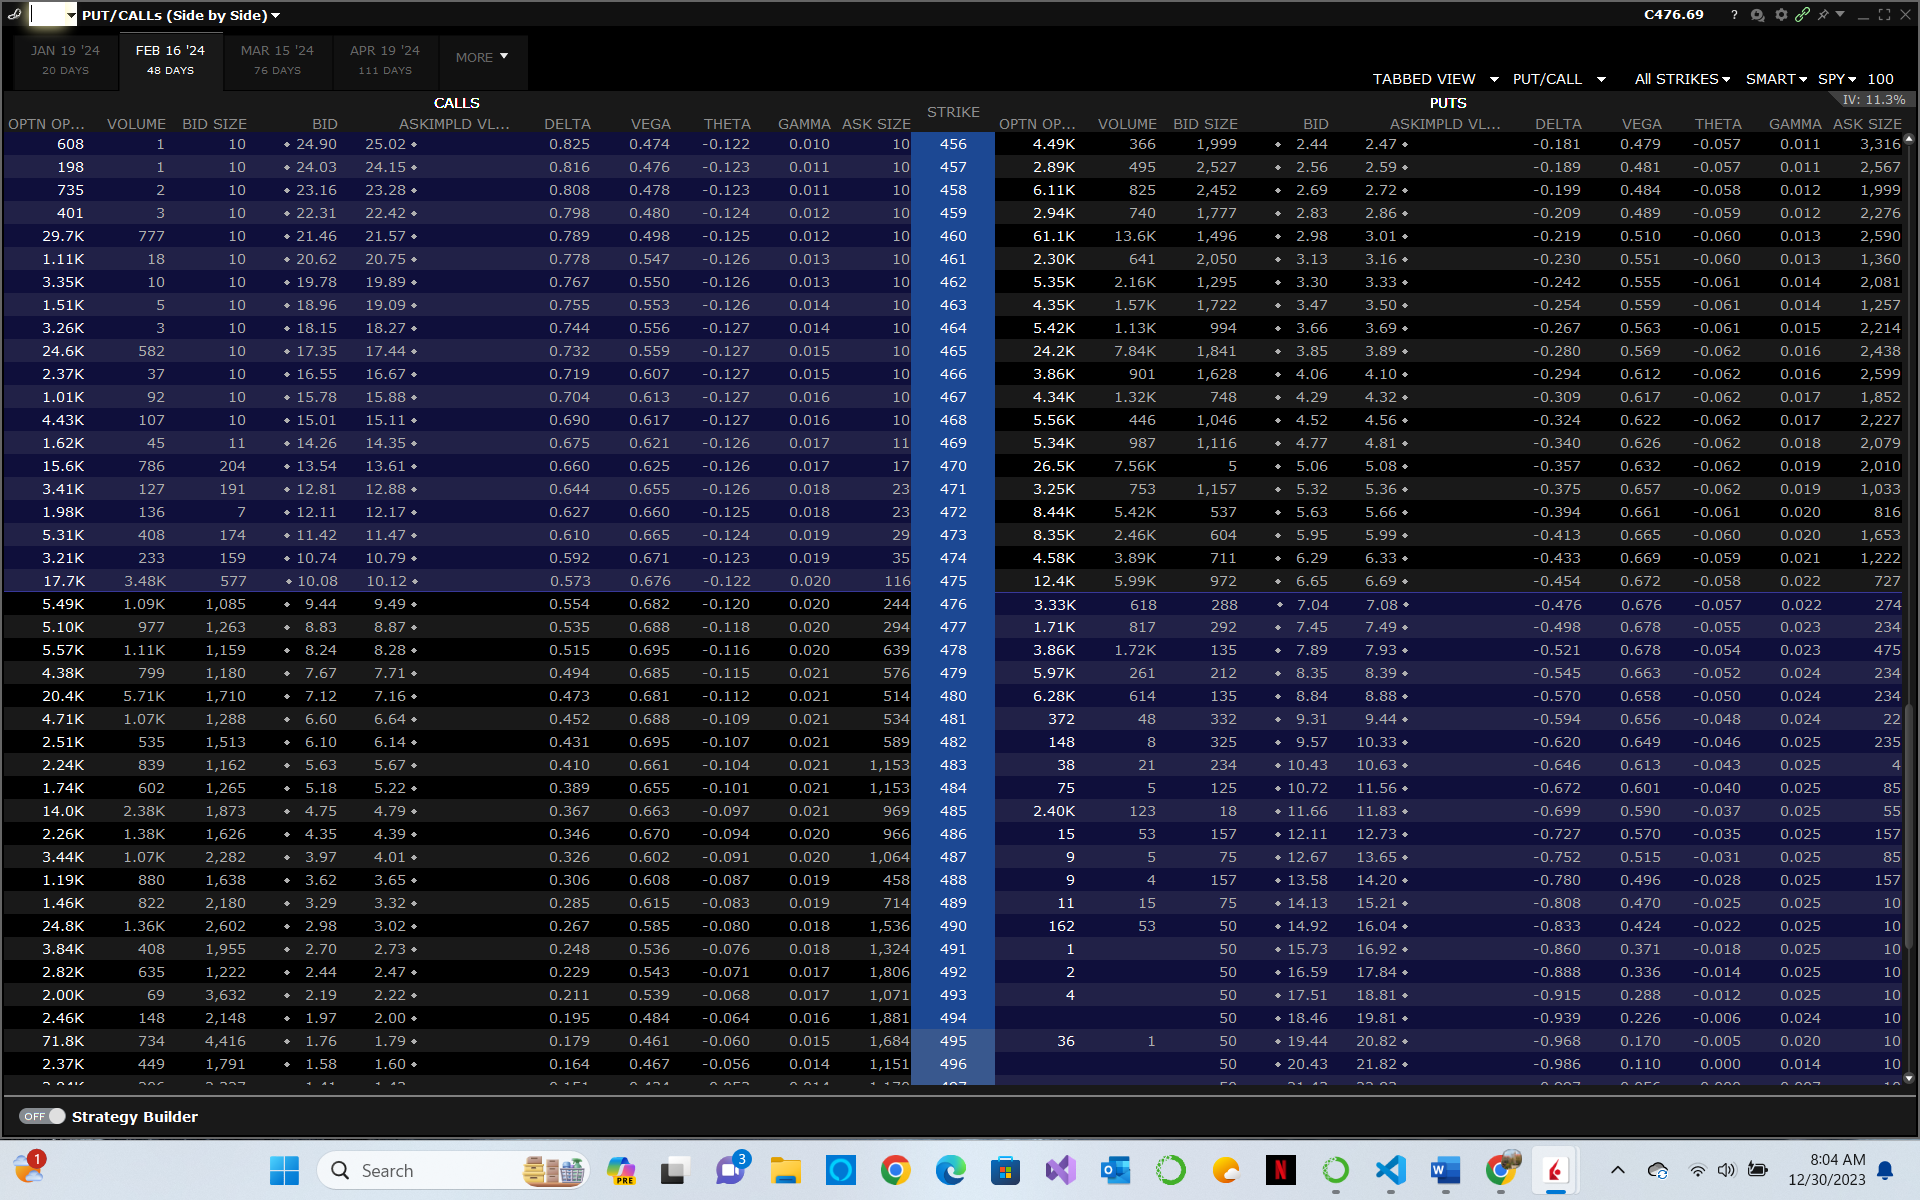

In [100]:
from IPython.display import Image

# Provide the path to your image file
image_path = 'spy_option_chain.png'

# Display the image
Image(filename=image_path)


In [101]:
# Let's define the  short straddle at 475 Using Real Pricing Data Above
Spy_spot = 475.07
rownames = ['Price','Delta','Gamma','Vega','Theta']
c475 = np.array([10.08,0.573,0.022,67.6,-0.122])*-1
p475 = np.array([5.56, -0.454,0.022,67.2,-0.058])*-1
short_straddle = pd.DataFrame([c475,p475],columns=rownames,index = ['C475','P475'])
#short_straddle.loc['Net_Position',:] = short_straddle.sum(axis = 0)
# Let's define long strangle c at 485 and p at 465
c485 = np.array([4.79,0.367,0.021,66.3,-0.097])
p465 = np.array([3.89,-0.280,0.016,56.9,0.062])
long_strangle = pd.DataFrame([c485, p465],columns=rownames,index=['C485','P65'])
Sstr_Lstrad = pd.concat([short_straddle,long_strangle])
Sstr_Lstrad.loc['Net_Position',:] = Sstr_Lstrad.sum(axis = 0)
Sstr_Lstrad

,Price,Delta,Gamma,Vega,Theta
C475,-10.08,-0.573,-0.022,-67.6,0.122
P475,-5.56,0.454,-0.022,-67.2,0.058
C485,4.79,0.367,0.021,66.3,-0.097
P65,3.89,-0.280,0.016,56.9,0.062
Net_Position,-6.96,-0.032,-0.007,-11.6,0.145


- I establish a credit of $\$6.96$
- Negative delta, gamma, and vega with posotive theta exposure

- Let's graph the expiration payoffs

In [102]:
spots_spy = np.linspace(430,500,num = 141)
SHORT_STRADDLE = -np.maximum(spots_spy-475,0) - np.maximum(475-spots_spy,0) + (10.08+5.56)
LONG_STRANGLE = np.maximum(spots_spy-485,0) + np.maximum(465-spots_spy,0) - (4.79+3.89)
IRON_BUTTERFLY = pd.DataFrame({'Short_Straddle':SHORT_STRADDLE,"Long_Strangle":LONG_STRANGLE,'Iron_Condor': SHORT_STRADDLE+LONG_STRANGLE},index=spots_spy)
IRON_BUTTERFLY.index.name = 'Spot'
fig5 = px.line(IRON_BUTTERFLY,title = 'Iron Butterfly = Short Straddle + Long Strangle')
fig5.update_layout(yaxis_title = f"Profits ($)")

If you are short a straddle sometimes it is wise to use a strangle to hedge your volatility risk